# Importa Bibliotecas

In [1]:
# Bibliotecas principais e gerenciamento de dados
import pandas as pd
import numpy as np
import pickle
import time
import itertools
from itertools import combinations

# Modelos e métricas de machine learning e estatística
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import kruskal, jarque_bera
import statsmodels.api as sm

# Otimização de ARIMA
import pmdarima as pm

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Barra de progresso
from tqdm import tqdm

# Gerenciamento de avisos
import warnings
warnings.filterwarnings("ignore")  # Ignora avisos para manter o output limpo

# Funções

In [2]:
def testar_estacionariedade(serie):
    resultado = adfuller(serie)
    print('ADF Statistic:', resultado[0])
    print('p-value:', resultado[1])
    if resultado[1] < 0.05:
        print('A série é estacionária')
    else:
        print('A série não é estacionária')

In [3]:
# Função para calcular o AIC de um modelo SARIMAX
def calculate_aic(exog_comb):
    try:
        model = SARIMAX(
            endog=df_train[target],
            exog=df_train[list(exog_comb)],
            order=order,  # Usando os valores já definidos
            seasonal_order=seasonal_order  # Usando os valores já definidos
        )
        fit = model.fit(disp=False)
        return fit.aic, fit  # Retorna o AIC e o modelo ajustado
    except Exception as e:
        print(f"Erro ao ajustar o modelo SARIMAX para {exog_comb}: {e}")
        return np.inf, None  # Retorna AIC infinito para combinações inválidas


In [4]:
# Função para calcular o VIF de uma combinação de variáveis
def check_multicollinearity(exog_comb, df_train):
    if len(exog_comb) < 2:  # Verifica se há pelo menos 2 variáveis na combinação
        return 0, pd.DataFrame()  # Retorna VIF 0 (nenhuma multicolinearidade possível)
    
    X = df_train[list(exog_comb)]
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data["VIF"].max(), vif_data  # Retorna o maior VIF e a tabela de VIFs

### Parâmetros

In [5]:
data_inicial = '20180101'
data_final = '20231201'

# define target
target = 'PD'

### Importa Bases

In [6]:
# Carregar e dados
df = pd.read_parquet('base.parquet')

### Tratamento Base

In [7]:
# corte temporal
df = df[df['DATA_REFERENCIA'] >= data_inicial]
df = df[df['DATA_REFERENCIA'] <= data_final]

# definindo índice
df.set_index('DATA_REFERENCIA', inplace=True)

# Verificar as primeiras linhas
df.head()

,PD,IPCA_LAG_1,IPCA_LAG_3,IPCA_LAG_6,IPCA_LAG_12,DESEMPREGO_LAG_1,DESEMPREGO_LAG_3,DESEMPREGO_LAG_6,DESEMPREGO_LAG_12,PIB_LAG_1,...,PIB_LAG_6,PIB_LAG_12,SELIC_LAG_1,SELIC_LAG_3,SELIC_LAG_6,SELIC_LAG_12,CAMBIO_LAG_1,CAMBIO_LAG_3,CAMBIO_LAG_6,CAMBIO_LAG_12
DATA_REFERENCIA,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3.861777,5.410274,5.159236,2.918972,4.657135,11.9,12.3,12.9,12.7,588892.8,...,557458.2,526564.7,6.675963,7.956187,10.033869,13.893348,3.291915,3.191229,3.206138,3.196609
2018-02-01,3.798198,3.536617,3.412864,2.303129,4.032747,12.3,12.1,12.7,13.3,555644.6,...,555578.7,514120.5,7.186373,7.058561,10.033869,10.954329,3.210609,3.259380,3.150917,3.104194
2018-03-01,3.815173,3.908738,5.410274,1.935750,3.040525,12.7,11.9,12.5,13.9,528905.5,...,528871.2,544312.9,5.788102,6.675963,7.956187,13.353730,3.241500,3.291915,3.134790,3.127930
2018-04-01,3.823845,1.084909,3.536617,5.159236,1.692904,13.2,12.3,12.3,13.7,560120.7,...,549304.7,525238.1,6.548709,7.186373,7.956187,9.902948,3.279214,3.210609,3.191229,3.136172
2018-05-01,3.876315,2.671660,3.908738,3.412864,3.784558,13.0,12.7,12.1,13.4,559359.8,...,566209.3,548887.7,6.421594,5.788102,7.058561,11.748906,3.407495,3.241500,3.259380,3.209509


### Separação Treino/Teste

In [8]:
# Separar em treino e teste
train_size = int(len(df) * 0.8)  
df_train = df.iloc[:train_size]
len(df_train)

57

In [9]:
test_size = len(df) - train_size
df_test = df.iloc[train_size:]
len(df_test)

15

### Definir Ordens do SARIMAX

In [10]:
# Nome do arquivo onde o modelo foi salvo
model_filename = 'modelo_sarima.pkl'

# Carregar o modelo do arquivo pickle
with open(model_filename, 'rb') as file:
    modelo_carregado = pickle.load(file)

In [11]:
# Obter as ordens do modelo
order = modelo_carregado.order
seasonal_order = modelo_carregado.seasonal_order

# Exibir as ordens
print(f"Order: {order}")
print(f"Seasonal Order: {seasonal_order}")

Order: (0, 1, 0)
Seasonal Order: (2, 0, 0, 3)


### Treinamento do Modelo

In [12]:
# Inicializar as variáveis para armazenar o melhor modelo
best_aic = np.inf
best_model = None
best_exog_comb = None

# Iniciar o processo backward stepwise
current_exog_vars = df_train.drop(columns=target).columns
while len(current_exog_vars) > 0:
    # Testar o AIC de cada combinação removendo uma variável de cada vez
    aic_with_removals = []
    models_with_removals = []
    
    for exog_comb in combinations(current_exog_vars, len(current_exog_vars) - 1):
        # Testar a multicolinearidade
        max_vif, vif_data = check_multicollinearity(exog_comb, df_train)
        
        # Depuração: mostrar quais combinações estão sendo testadas
        print(f"Testando combinação: {exog_comb}, Maior VIF: {max_vif}")
        
        # Continuar apenas se não houver alta multicolinearidade
        if max_vif <= 5:  # Limite para alta multicolinearidade
            aic, model = calculate_aic(exog_comb)
            aic_with_removals.append((aic, exog_comb))
            models_with_removals.append(model)
        else:
            print(f"Alta multicolinearidade detectada para {exog_comb}. Detalhes: \n{vif_data}")
    
    # Se não houver nenhuma combinação válida nesta etapa, apenas reduza o conjunto de variáveis
    if not aic_with_removals:
        print("Nenhuma combinação válida encontrada nesta etapa.")
        current_exog_vars = current_exog_vars[:-1]  # Remove uma variável arbitrária para continuar
        continue
    
    # Selecionar a combinação com o menor AIC
    best_aic_for_step, best_exog_for_step = min(aic_with_removals, key=lambda x: x[0])
    
    # Atualizar o melhor AIC e a melhor combinação de variáveis exógenas
    if best_aic_for_step < best_aic:
        best_aic = best_aic_for_step
        best_exog_comb = best_exog_for_step
        best_model = models_with_removals[aic_with_removals.index((best_aic_for_step, best_exog_for_step))]
        current_exog_vars = list(best_exog_comb)  # Atualizar para a melhor combinação
    else:
        # Caso não haja melhora no AIC, remova uma variável arbitrária e continue
        current_exog_vars = current_exog_vars[:-1]

# Resultado final
if best_model is not None:
    print(f"Melhor modelo encontrado com AIC: {best_aic} e variáveis: {best_exog_comb}")
else:
    print("Nenhum modelo válido foi encontrado.")

Testando combinação: ('IPCA_LAG_1', 'IPCA_LAG_3', 'IPCA_LAG_6', 'IPCA_LAG_12', 'DESEMPREGO_LAG_1', 'DESEMPREGO_LAG_3', 'DESEMPREGO_LAG_6', 'DESEMPREGO_LAG_12', 'PIB_LAG_1', 'PIB_LAG_3', 'PIB_LAG_6', 'PIB_LAG_12', 'SELIC_LAG_1', 'SELIC_LAG_3', 'SELIC_LAG_6', 'SELIC_LAG_12', 'CAMBIO_LAG_1', 'CAMBIO_LAG_3', 'CAMBIO_LAG_6'), Maior VIF: 1534.3815862583908
Alta multicolinearidade detectada para ('IPCA_LAG_1', 'IPCA_LAG_3', 'IPCA_LAG_6', 'IPCA_LAG_12', 'DESEMPREGO_LAG_1', 'DESEMPREGO_LAG_3', 'DESEMPREGO_LAG_6', 'DESEMPREGO_LAG_12', 'PIB_LAG_1', 'PIB_LAG_3', 'PIB_LAG_6', 'PIB_LAG_12', 'SELIC_LAG_1', 'SELIC_LAG_3', 'SELIC_LAG_6', 'SELIC_LAG_12', 'CAMBIO_LAG_1', 'CAMBIO_LAG_3', 'CAMBIO_LAG_6'). Detalhes: 
             variable          VIF
0          IPCA_LAG_1     4.365893
1          IPCA_LAG_3     5.153723
2          IPCA_LAG_6     6.269466
3         IPCA_LAG_12     4.317517
4    DESEMPREGO_LAG_1  1509.880144
5    DESEMPREGO_LAG_3  1345.218244
6    DESEMPREGO_LAG_6   600.381714
7   DESEMPREGO_

In [13]:
# Resultado final
print(f"Melhor AIC encontrado: {best_aic}")
print(f"Melhor combinação de variáveis exógenas: {best_exog_comb}")
print(best_model.summary())

Melhor AIC encontrado: -77.28295998061317
Melhor combinação de variáveis exógenas: ('IPCA_LAG_6',)
                                     SARIMAX Results                                     
Dep. Variable:                                PD   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 3)   Log Likelihood                  42.641
Date:                           Tue, 10 Jun 2025   AIC                            -77.283
Time:                                   07:31:28   BIC                            -69.182
Sample:                               01-01-2018   HQIC                           -74.142
                                    - 09-01-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IPCA_LAG_6    -0.0033  

### R2 em Treino

In [14]:
# Fazer previsões dentro do conjunto de treino (ou teste, se preferir)
y_true = df_train[target].iloc[1:]  # Ajuste conforme o período de interesse
y_pred_train = best_model.predict(start=1, end=len(df_train[target]) - 1, exog=df_train[list(best_exog_comb)].iloc[1:])

# Calcular o R² ajustado
n = len(y_true)
p = len(best_exog_comb)  # Número de variáveis exógenas selecionadas
r2 = r2_score(y_true, y_pred_train)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R²: {r2}")
print(f"R² ajustado: {adjusted_r2}")

R²: 0.7310803357573444
R² ajustado: 0.726100341975073


### Predições em Teste

In [15]:
# Fazer previsões com base em df_test
y_pred_test = best_model.predict(start=len(df_train), 
                                   end=len(df_train) + len(df_test) - 1,
                                   exog=df_test[list(best_exog_comb)])

# Exibir as previsões
print(y_pred_test) 

2022-10-01    3.274342
2022-11-01    3.231395
2022-12-01    3.202265
2023-01-01    3.256622
2023-02-01    3.319279
2023-03-01    3.313220
2023-04-01    3.219228
2023-05-01    3.251470
2023-06-01    3.254748
2023-07-01    3.268633
2023-08-01    3.209401
2023-09-01    3.214731
2023-10-01    3.249703
2023-11-01    3.260022
2023-12-01    3.265752
Freq: MS, Name: predicted_mean, dtype: float64


### Análise dos Resíduos



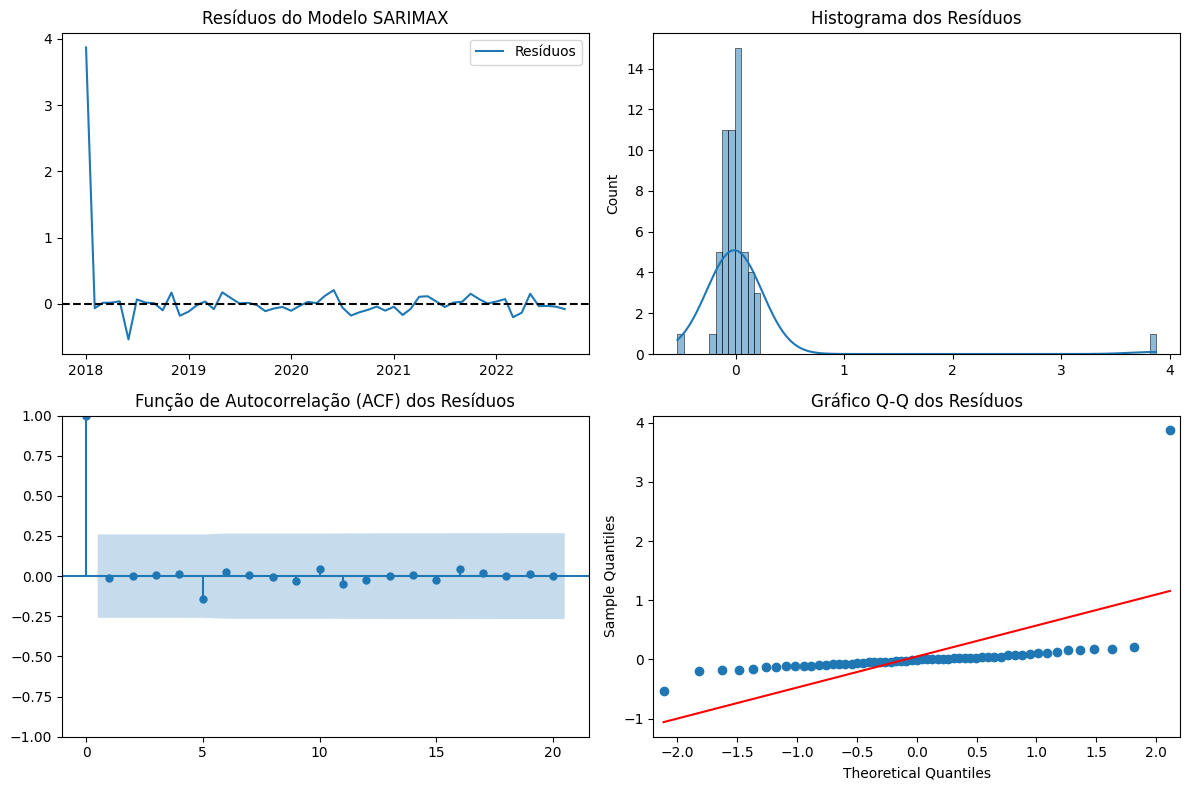


Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: 5646.7503
   - p-valor: 0.0000
   Os resíduos não seguem uma distribuição normal.

2. Teste de Ljung-Box (lag 10):
   - Estatística: 1.6221
   - p-valor: 0.9985
   Não há autocorrelação significativa nos resíduos.

3. Teste de Breusch-Pagan:
   - Estatística LM: 0.3019
   - p-valor LM: 0.5827
   - Estatística F: 0.2929
   - p-valor F: 0.5906
   Os resíduos possuem variância constante (homocedasticidade).



In [16]:
# Pegando os resíduos do modelo ARIMA
residuos = best_model.resid  # Chamar o método resid()

# Ajustando o erro no teste Jarque-Bera 
jb_stat, jb_pvalue = jarque_bera(residuos)

# Teste Ljung-Box
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)

# Teste de Breusch-Pagan
X = sm.add_constant(df_train[list(best_exog_comb)])
bp_test = het_breuschpagan(residuos, X)
bp_stat, bp_pvalue, bp_f_stat, bp_f_pvalue = bp_test

# Criando os gráficos
plt.figure(figsize=(12, 8))

# Gráfico de resíduos
plt.subplot(2, 2, 1)
plt.plot(residuos, label='Resíduos')
plt.axhline(0, color='black', linestyle='--')
plt.title('Resíduos do Modelo SARIMAX')
plt.legend()

# Histograma dos resíduos
plt.subplot(2, 2, 2)
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')

# ACF dos resíduos
plt.subplot(2, 2, 3)
sm.graphics.tsa.plot_acf(residuos, ax=plt.gca(), lags=20)
plt.title('Função de Autocorrelação (ACF) dos Resíduos')

# Q-Q plot
plt.subplot(2, 2, 4)
sm.qqplot(residuos, line='s', ax=plt.gca())
plt.title('Gráfico Q-Q dos Resíduos')

plt.tight_layout()
plt.show()

# Interpretando os resultados
interpretation = f"""
Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: {jb_stat:.4f}
   - p-valor: {jb_pvalue:.4f}
   {'Os resíduos seguem uma distribuição normal.' if jb_pvalue > 0.05 else 'Os resíduos não seguem uma distribuição normal.'}

2. Teste de Ljung-Box (lag 10):
   - Estatística: {ljung_box_test['lb_stat'].values[0]:.4f}
   - p-valor: {ljung_box_test['lb_pvalue'].values[0]:.4f}
   {'Não há autocorrelação significativa nos resíduos.' if ljung_box_test['lb_pvalue'].values[0] > 0.05 else 'Há autocorrelação significativa nos resíduos.'}

3. Teste de Breusch-Pagan:
   - Estatística LM: {bp_stat:.4f}
   - p-valor LM: {bp_pvalue:.4f}
   - Estatística F: {bp_f_stat:.4f}
   - p-valor F: {bp_f_pvalue:.4f}
   {'Os resíduos possuem variância constante (homocedasticidade).' if bp_pvalue > 0.05 else 'Os resíduos apresentam heterocedasticidade (variância não constante).'}
"""

print(interpretation)

### Vizualização Gráfica

In [17]:
# Comparar as previsões com os valores reais
result = pd.DataFrame({
    'Real': df_test[target],  # Selecionar apenas a coluna target do DataFrame
    'Previsão': y_pred_test
})

# Exibir o resultado
print(result)

                Real  Previsão
2022-10-01  3.159615  3.274342
2022-11-01  3.187230  3.231395
2022-12-01  3.158198  3.202265
2023-01-01  3.091412  3.256622
2023-02-01  3.203317  3.319279
2023-03-01  3.192858  3.313220
2023-04-01  3.218239  3.219228
2023-05-01  3.258903  3.251470
2023-06-01  3.286762  3.254748
2023-07-01  3.364353  3.268633
2023-08-01  3.207965  3.209401
2023-09-01  3.235853  3.214731
2023-10-01  3.238519  3.249703
2023-11-01  3.284994  3.260022
2023-12-01  3.316661  3.265752


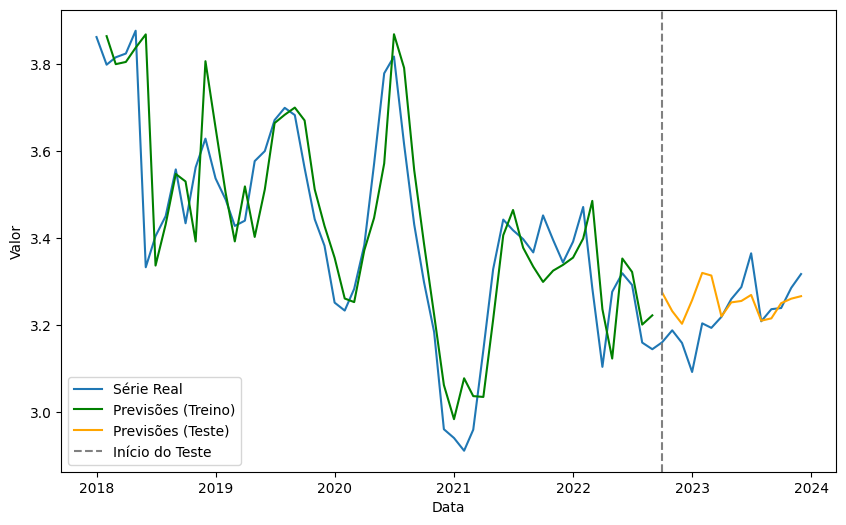

In [18]:
# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[target], label='Série Real')
plt.plot(y_pred_train.index, y_pred_train, label='Previsões (Treino)', color='green')
plt.plot(y_pred_test.index, y_pred_test, label='Previsões (Teste)', color='orange')
plt.axvline(x=df_test.index[0], color='gray', linestyle='--', label='Início do Teste')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

### Métricas em Treino

In [34]:
# Remover o primeiro valor de fitted_values para alinhar as séries (percorrendo combinações com 5 variáveis)
fitted_values_aligned = np.array(y_pred_train)
actual_values = df_train[target].iloc[1:].values


rmse_arima_test = np.sqrt(mean_squared_error(actual_values, fitted_values_aligned))
mae_arima_test = mean_absolute_error(actual_values, fitted_values_aligned)
mape_arima_test = np.mean(np.abs((actual_values - fitted_values_aligned) / actual_values)) * 100

print(f'RMSE: {rmse_arima_test}')
print(f'MAE: {mae_arima_test}')
print(f"MAPE: {mape_arima_test:.2f}%")

RMSE: 0.11794154859886691
MAE: 0.08449035428896123
MAPE: 2.50%


### Métricas em Teste

In [43]:
# Remover o primeiro valor de fitted_values para alinhar as séries (percorrendo combinações com 5 variáveis)
#fitted_values_aligned = best_model.predict(start=1, end=len(df_test[target]) - 1, exog=df_test[list(best_exog_comb)].iloc[1:]).values
fitted_values_aligned = np.array(y_pred_test)[:-1]
actual_values = df_test[target].iloc[1:].values


rmse_arima_test = np.sqrt(mean_squared_error(actual_values, fitted_values_aligned))
mae_arima_test = mean_absolute_error(actual_values, fitted_values_aligned)
mape_arima_test = np.mean(np.abs((actual_values - fitted_values_aligned) / actual_values)) * 100

print(f'RMSE: {rmse_arima_test}')
print(f'MAE: {mae_arima_test}')
print(f"MAPE: {mape_arima_test:.2f}%")

RMSE: 0.074312240527744
MAE: 0.06666280841293497
MAPE: 2.07%


### Salvando Modelo

In [21]:
# Nome do arquivo onde o modelo será salvo
model_filename = 'modelo_sarimax_completo.pkl'

# Salvando o modelo em um arquivo pickle
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Modelo salvo em: {model_filename}")

Modelo salvo em: modelo_sarimax_completo.pkl
